# Uber打车用户留存情况预测

## 1. 项目概况
----
### 1.1 项目背景与定义
为了辨别打车用户特征对于留存情况的影响以进一步提高用户留存率，Uber公开了50,000名于2014年1月注册Uber账户的用户部分信息，希望基于该信息得到具有相对可靠性及参考意义的预测模型。  
为解决该二分类问题，本项目将实际运用Python相关库（Pandas, Numpy,Matplotlib, Scikit-learn等）进行分类模型的筛选、细化与评估，在得到可靠模型的同时，输出客户各特征对于Uber留存率的重要度。
### 1.2 项目流程
* 数据前处理与特征工程
    * 数据探索分析
    * 数值型特征缺失值处理
    * 数值型特征异常点检测
    * 留存用户标签定义
    * 数据可视化与特征关联性分析
    * 类别型特征指示变量转换
    * 日期型特征离散
* 分类模型筛选
    * 定义模型评分依据
    * 尝试不同分类模型并筛选表现较好模型
* 模型交叉验证与调优
    * 利用GridSearchCV调优得到max_depth, max_features, n_estimators参数较优值
* 模型验证与评估
    * 通过学习曲线评估模型随复杂度变化的表现情况
* 结论
    * 给出特征重要度排名

## 2. 数据前处理与特征工程
----

### 2.1 数据集概述
* `city`: 用户注册所在城市
* `phone`: 用户使用的手机系统
* `signup_date`: 账户注册日期，格式为‘YYYY-MM-DD’
* `last_trip_date`: 用户最近一次打车日期，格式为‘YYYY-MM-DD’
* `avg_dist`: 用户注册后前30天内平均打车距离（英里）
* `avg_rating_by_driver`: 司机对该用户打分的平均值
* `avg_rating_of_driver`: 该用户对所有司机打分的平均值
* `surge_pct`: 用户紧急叫车次数占总乘车次数的百分比
* `avg_surge`: 用户紧急叫车的平均加价倍率
* `trips_in_first_30_days`: 用户注册后前30天内的总乘车次数
* `uber_black_user`: 是否为UberBlack级别车用户
* `weekday_pct`: 用户工作日打车占比

### 2.2 数据探索分析

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# 加载数据
with open('train.json', 'r') as f:
    data = json.load(f)
df = pd.DataFrame(data)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,uber_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [3]:
# 各字段统计值
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [4]:
df1 = df.copy()

### 2.3 数值型特征缺失值处理

In [5]:
# 查看各字段缺失值情况
df1.isnull().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
uber_black_user              0
weekday_pct                  0
dtype: int64

avg_rating_by_driver, avg_rating_of_driver和phone三个字段存在缺失值，处理方法：
* avg_rating_by_driver、avg_rating_of_driver字段：用各自统计的中位数填充
* phone字段：直接删除对应的行


In [6]:
# avg_rating_by_driver、avg_rating_of_driver字段：用各自统计的中位数填充

df1['avg_rating_by_driver'].fillna(df1['avg_rating_by_driver'].median(), inplace=True)
df1['avg_rating_of_driver'].fillna(df1['avg_rating_of_driver'].median(), inplace=True)


In [7]:
# phone字段：直接删除对应的行

df1 = df1.drop(index=df[df.phone.isnull()].index).reset_index(drop=True)


In [8]:
df1.isnull().sum()

avg_dist                  0
avg_rating_by_driver      0
avg_rating_of_driver      0
avg_surge                 0
city                      0
last_trip_date            0
phone                     0
signup_date               0
surge_pct                 0
trips_in_first_30_days    0
uber_black_user           0
weekday_pct               0
dtype: int64

### 2.4 数值型特征异常点检测

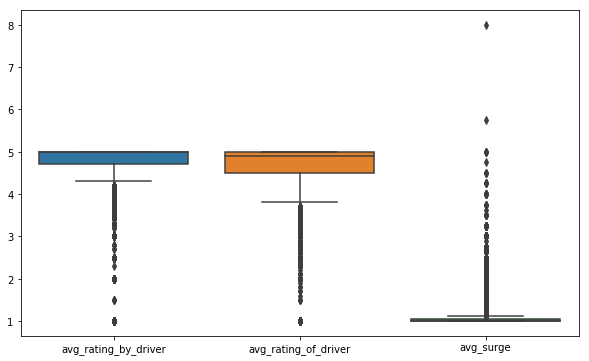

In [9]:
# 利用箱体图描述各字段分布情况

fig, ax = plt.subplots(figsize=(10,6))

sns.boxplot(data=df1[['avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge']])

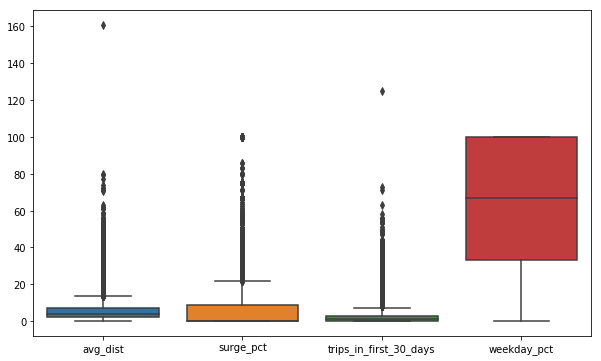

In [10]:
fig, ax = plt.subplots(figsize=(10,6))

sns.boxplot(data=df1[['avg_dist', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']])

统计各记录异常点情况

In [11]:
# 统计各记录异常点情况
df1['outlier_counts'] = 0

def outlier_count(df, numeric_features):
    for feature in numeric_features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        interquantile = Q3 - Q1
        outlier_series = df[feature].apply(lambda x: 1 if ((x >= Q3 + 1.5 * interquantile) or (x <= Q1 - 1.5 * interquantile)) else 0)
        count1 = outlier_series.sum()
        print('Number of Outliers for %s : %d' % (feature, count1))
        df['outlier_counts'] = df['outlier_counts'] + outlier_series
    return df

各字段推断异常点的数量

In [12]:
numeric_features = ['avg_rating_by_driver','avg_rating_of_driver', 'avg_surge',
                    'avg_dist', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']
df1 = outlier_count(df1, numeric_features)

Number of Outliers for avg_rating_by_driver : 3922
Number of Outliers for avg_rating_of_driver : 3106
Number of Outliers for avg_surge : 8369
Number of Outliers for avg_dist : 4477
Number of Outliers for surge_pct : 6768
Number of Outliers for trips_in_first_30_days : 3153
Number of Outliers for weekday_pct : 0


同时有两项特征存在异常值的记录数

In [13]:
(df1.outlier_counts >= 2).sum()

7805

删除同时有两项特征存在异常值的记录

In [14]:
df1 = df1.drop(index=df1[df1.outlier_counts >= 2].index).reset_index(drop=True)

In [15]:
df1.shape[0]

41799

In [16]:
df1.drop(['outlier_counts'], axis=1, inplace=True)

### 2.5 非数值型特征

类别型特征：city, phone, uber_black_user

In [17]:
print('city : \n')
print(df1.city.value_counts())
print('\n')
print('phone : \n')
print(df1.phone.value_counts())
print('\n')
print('uber_black_user : \n')
print(df1.uber_black_user.value_counts())

city : 

Winterfell        19838
Astapor           13619
King's Landing     8342
Name: city, dtype: int64


phone : 

iPhone     28988
Android    12811
Name: phone, dtype: int64


uber_black_user : 

False    25469
True     16330
Name: uber_black_user, dtype: int64


时间性特征 : signup_date,  last_trip_date

In [18]:
print('signup_date: max = %s, min = %s' % (df1.signup_date.max(), df.signup_date.min()))
print('last_trip_date: max = %s, min = %s' % (df1.last_trip_date.max(), df.last_trip_date.min()))

signup_date: max = 2014-01-31, min = 2014-01-01
last_trip_date: max = 2014-07-01, min = 2014-01-01


将2014-07-01之前30天内有有车记录的用户定义为留存用户

In [19]:
df1['retained'] = df1.last_trip_date >= '2014-06-01'

In [20]:
df1.drop(['last_trip_date'], axis=1, inplace=True)

留存用户约占总体用户的37%

In [21]:
df1.retained.mean()

0.37405201081365586

留存用户约占总体用户的37%

### 2.6 数据可视化与特征关联性分析

对于数值型特征，采用Pair Scatter Plot与correlation matrix进行相关性分析

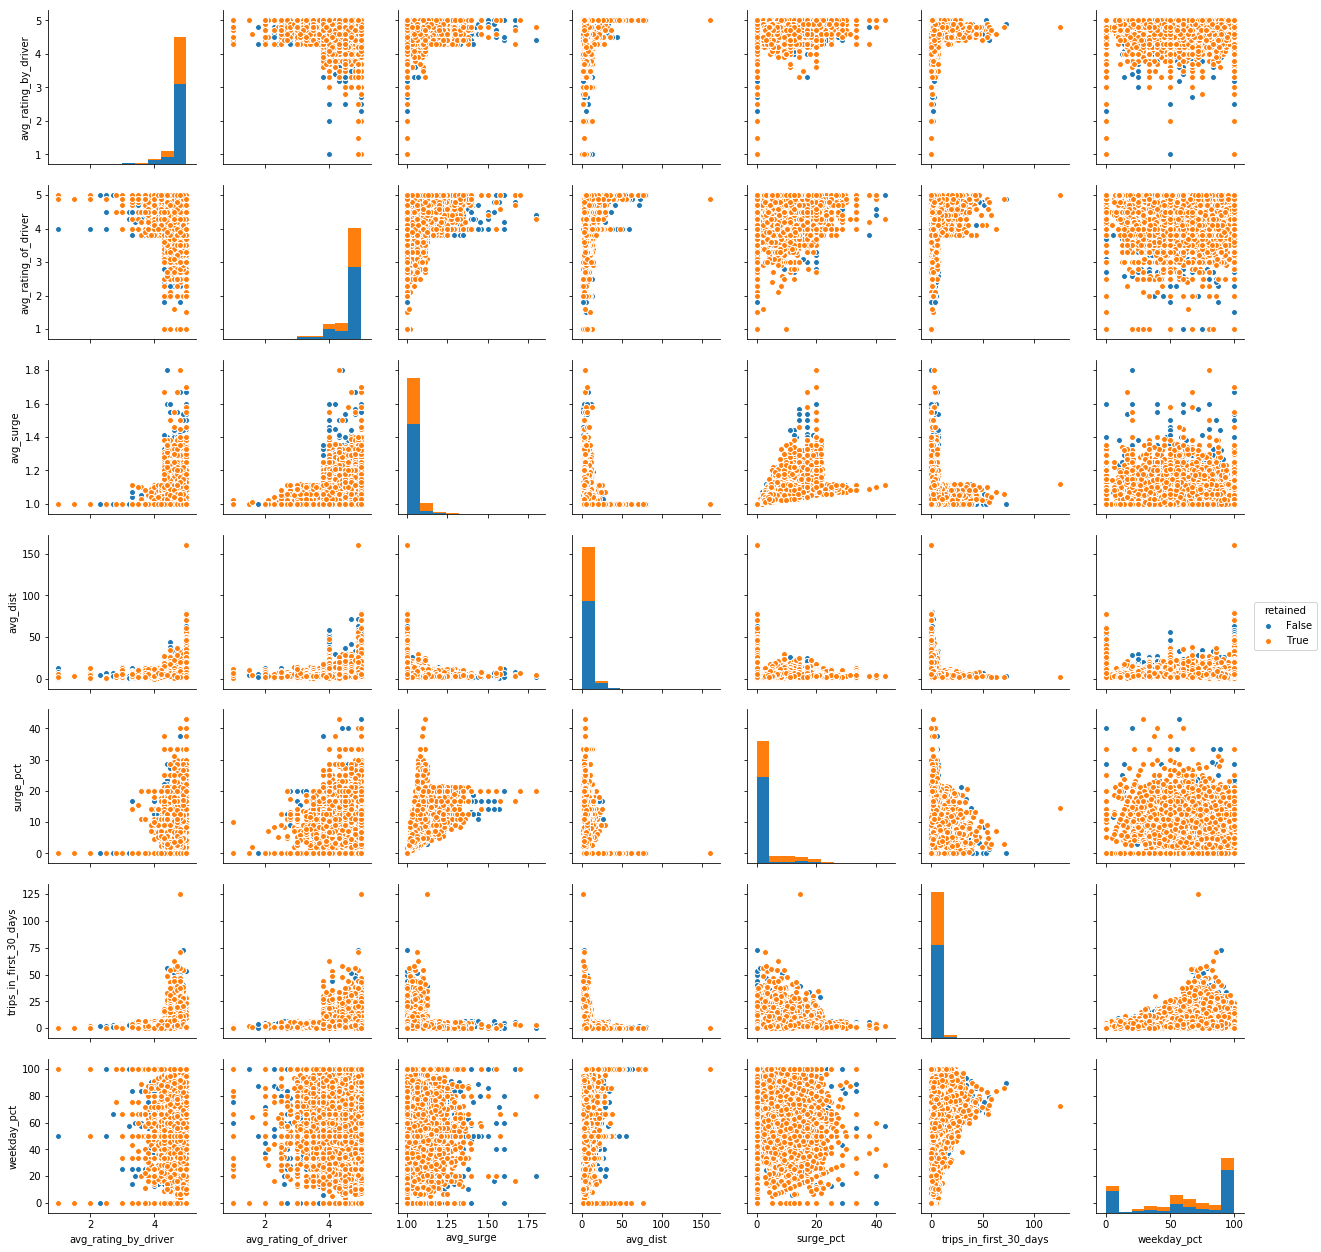

In [22]:
num_feat = ['avg_rating_by_driver','avg_rating_of_driver', 'avg_surge',
            'avg_dist', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct','retained']
sns.pairplot(df1[num_feat],
            hue='retained',
            vars=['avg_rating_by_driver','avg_rating_of_driver', 'avg_surge',
                  'avg_dist', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']
            )

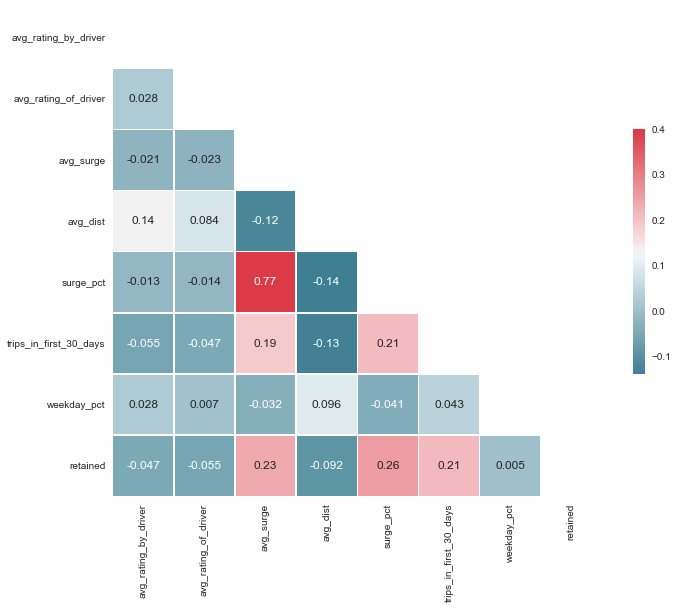

In [23]:
def corr_plot(df, num_feat):
    sns.set(style='white')
    
    corr = df[num_feat].corr()
    
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11,9))

    cmap = sns.diverging_palette(220,10,as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.4, annot=True,
           square=True, linewidths=0.5, cbar_kws={'shrink':.5}, ax=ax)

corr_plot(df1, num_feat)
    

对于类别型数据，采用barplot进行可视化分析

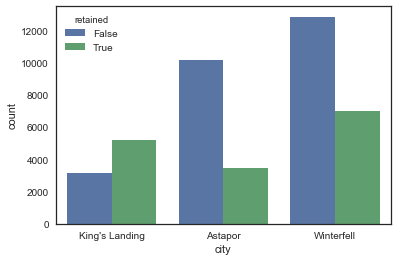

In [24]:
sns.countplot(x='city', hue='retained', data=df1)

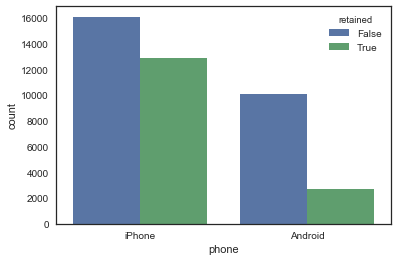

In [25]:
sns.countplot(x='phone', hue='retained', data=df1)

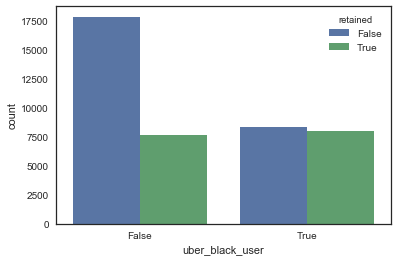

In [26]:
sns.countplot(x='uber_black_user', hue='retained', data=df1)

类别/日期型标签转化为数值型标签

In [27]:
df_city = pd.get_dummies(df1.city,prefix='city')
df1 = pd.concat([df1, df_city], axis=1)

In [28]:
df_phone = pd.get_dummies(df1.phone, prefix='phone')
df1 = pd.concat([df1, df_phone], axis=1)

In [29]:
def signup_date_convert(date):
    if date < '2014-01-05':
        return 0
    elif date < '2014-01-10':
        return 1
    elif date < '2014-01-15':
        return 2
    elif date < '2014-01-20':
        return 3
    elif date < '2014-01-25':
        return 4
    else:
        return 5


In [30]:
df1.signup_date = df1.signup_date.apply(signup_date_convert)

In [31]:
df1.drop(['city', 'phone'], axis=1, inplace=True)

In [32]:
df1.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,signup_date,surge_pct,trips_in_first_30_days,uber_black_user,weekday_pct,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,3.67,5.0,4.7,1.1,5,15.4,4,True,46.2,True,0,1,0,0,1
1,8.26,5.0,5.0,1.0,5,0.0,0,False,50.0,False,1,0,0,1,0
2,0.77,5.0,4.3,1.0,1,0.0,3,False,100.0,False,1,0,0,0,1
3,10.56,5.0,3.5,1.0,1,0.0,2,True,100.0,True,0,0,1,0,1
4,3.95,4.0,4.9,1.0,4,0.0,1,False,100.0,False,1,0,0,1,0


In [33]:
df1.dtypes

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
signup_date                 int64
surge_pct                 float64
trips_in_first_30_days      int64
uber_black_user              bool
weekday_pct               float64
retained                     bool
city_Astapor                uint8
city_King's Landing         uint8
city_Winterfell             uint8
phone_Android               uint8
phone_iPhone                uint8
dtype: object

## 3. 模型筛选

定义模型评估依据

In [34]:
from sklearn.metrics import roc_auc_score

def performance_metric(y_true, y_pred):
    score = roc_auc_score(y_true, y_pred)
    return score

划分训练集和测试集

In [35]:
from sklearn.cross_validation import train_test_split

y = df1['retained']
X = df1.drop(['retained'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [36]:
X_test.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,signup_date,surge_pct,trips_in_first_30_days,uber_black_user,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
15233,1.23,3.0,5.0,1.0,4,0.0,2,False,100.0,0,0,1,0,1
37446,15.99,5.0,5.0,1.0,2,0.0,1,False,100.0,0,1,0,0,1
34578,3.03,4.8,4.0,1.0,3,0.0,5,True,100.0,1,0,0,1,0
32333,7.62,5.0,4.5,1.0,3,0.0,0,True,30.8,0,1,0,0,1
1813,25.93,5.0,4.9,1.0,2,0.0,1,True,0.0,0,0,1,0,1


尝试并筛选分类模型

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

clf_lr = LogisticRegression()
clf_svc = SVC()
clf_knn = KNeighborsClassifier()
clf_rf = RandomForestClassifier()

In [38]:
for clf in (clf_lr, clf_svc, clf_knn, clf_rf):
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    print(clf.__class__.__name__)
    print('Score on training dataset : ', performance_metric(y_train, y_train_pred))
    print('Score on test dataset : ', performance_metric(y_test, y_test_pred))

LogisticRegression
Score on training dataset :  0.6841050685926416
Score on test dataset :  0.6936245857781221
SVC
Score on training dataset :  0.7794541297288773
Score on test dataset :  0.7409838438260743
KNeighborsClassifier
Score on training dataset :  0.7960169470894022
Score on test dataset :  0.721543165526463
RandomForestClassifier
Score on training dataset :  0.9748921206002594
Score on test dataset :  0.7189725193641473


随机森林模型相较于其他模型表现较好，选定该模型进行进一步细化与调参。

## 4. 模型调参

利用GridSearchCV进行模型交叉验证调优

In [39]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.cross_validation import ShuffleSplit

C:\Users\user\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [40]:
# 对max_depth、max_features进行参数调优
def rf_fit_model(X, y):
    
    cv_sets = ShuffleSplit(X.shape[0], test_size=0.3, random_state=1, n_iter=10)
    
    rf_clf = RandomForestClassifier(random_state=1)
    parameters = {
        'max_depth':[1,2,3,4,5,6,7,8,9,10],
        'max_features':[1,2,3,4,5,6,7,8,9,10,11],
#        'n_estimators':[10,20,30,40,50,60,70,80,90,100],
    }
    
    scoring_func = make_scorer(performance_metric)
    grid_obj = GridSearchCV(rf_clf, param_grid=parameters, scoring=scoring_func, cv=cv_sets) 
    
    grid_obj = grid_obj.fit(X, y)
    
    return grid_obj.best_estimator_

In [41]:
clf = rf_fit_model(X_train, y_train)

In [42]:
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [43]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print("Tuned model produces for training dataset an AUC score of ", performance_metric(y_train, y_train_pred))
print("Tuned model produces for test dataset an AUC score of ", performance_metric(y_test, y_test_pred))
print("Tuned model employs an max_depth of ", clf.get_params()['max_depth'])
print("Tuned model employs an max_features of ", clf.get_params()['max_features'])

Tuned model produces for training dataset an AUC score of  0.7593938939610745
Tuned model produces for test dataset an AUC score of  0.7640681532854529
Tuned model employs an max_depth of  6
Tuned model employs an max_features of  9


In [44]:
# 在调优后的max_depth, max_features基础上，继续对n_estimators参数进行调优

cv_sets = ShuffleSplit(X.shape[0], test_size=0.3, n_iter=10, random_state=1)
rfr = RandomForestClassifier(random_state=1, max_depth=6, max_features=8)
parameters = {'n_estimators':[10,20,30,50,70,100,150,200,500]}
scoring_func = make_scorer(performance_metric)
grid_obj = GridSearchCV(rfr, param_grid=parameters, cv=cv_sets, scoring=scoring_func)
grid_obj = grid_obj.fit(X,y)

clf = grid_obj.best_estimator_

In [45]:
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [46]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print("Tuned model produces for training dataset an AUC score of ", performance_metric(y_train, y_train_pred))
print("Tuned model produces for test dataset an AUC score of ", performance_metric(y_test, y_test_pred))

Tuned model produces for training dataset an AUC score of  0.7555624338810432
Tuned model produces for test dataset an AUC score of  0.7660540396340655


## 5. 模型验证与评估

通过learning curve,评估模型随数据量变化的可靠度

In [47]:
import sklearn.learning_curve as curves

def max_features_curve(X,y):
    
    cv_sets = ShuffleSplit(X.shape[0], test_size=0.3, n_iter=10, random_state=1)
    clf = RandomForestClassifier(max_depth=6, n_estimators=200, random_state=1)
    max_features_range = range(1,12)
    
    train_scores, test_scores = curves.validation_curve(clf, X, y, param_name='max_features', param_range=max_features_range,
                                                        cv=cv_sets, scoring='roc_auc',)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(train_scores, axis=1)
    
    plt.figure(figsize=(7,5))
    plt.plot(max_features_range, train_scores_mean, '-o', color='r', label='Training_Scores_Mean')
    plt.plot(max_features_range, test_scores_mean, '-o', color='b', label='TestScores_Mean')
    plt.fill_between(max_features_range, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, color='r', alpha=0.2)
    plt.fill_between(max_features_range, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std, color='r', alpha=0.2)
    
    plt.title('Random Forest Classifier Complexity Performance')
    plt.legend(loc='best')
    plt.xlabel('max_features')
    plt.ylabel('roc_auc')
    plt.ylim([0.83,0.85])

def max_depth_curve(X,y):
    
    cv_sets = ShuffleSplit(X.shape[0], test_size=0.3, n_iter=10, random_state=1)
    clf = RandomForestClassifier(max_features=8, n_estimators=200, random_state=1)
    max_depth_range = range(1,11)
    
    train_scores, test_scores = curves.validation_curve(clf, X, y, param_name='max_depth', param_range=max_depth_range,
                                                        cv=cv_sets, scoring='roc_auc',)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(train_scores, axis=1)
    
    plt.figure(figsize=(10,6))
    plt.plot(max_depth_range, train_scores_mean, '-o', color='r', label='Training_Scores_Mean')
    plt.plot(max_depth_range, test_scores_mean, '-o', color='b',  label='TestScores_Mean')
    plt.fill_between(max_depth_range, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, color='r', alpha=0.2)
    plt.fill_between(max_depth_range, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std, color='r', alpha=0.2)
    
    plt.title('Random Forest Classifier Complexity Performance')
    plt.legend(loc='best')
    plt.xlabel('max_depth')
    plt.ylabel('roc_auc')
    plt.ylim([0.60,0.95])

C:\Users\user\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


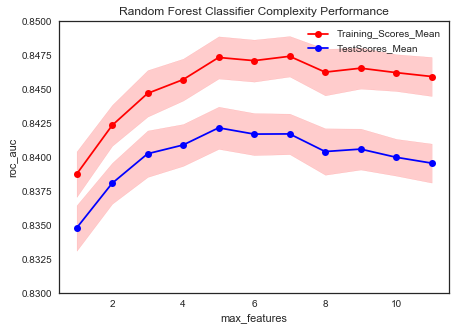

In [48]:
max_features_curve(X, y)

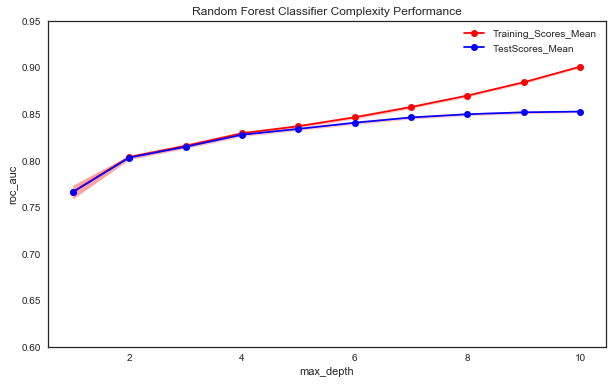

In [49]:
max_depth_curve(X, y)

In [50]:
clf = RandomForestClassifier(n_estimators=200, max_features=5, max_depth=9, random_state=1)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print("Tuned model produces for training dataset an AUC score of ", performance_metric(y_train, y_train_pred))
print("Tuned model produces for test dataset an AUC score of ", performance_metric(y_test, y_test_pred))

Tuned model produces for training dataset an AUC score of  0.7814827397745683
Tuned model produces for test dataset an AUC score of  0.7637462305703645


Text(0,0.5,'True Positive Rate')

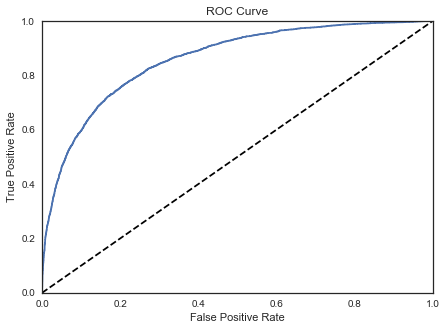

In [56]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = roc_auc_score(y_test, y_test_pred)

plt.figure(figsize=(7,5))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='ROC curve (area=%.4f)' % roc_auc)
plt.plot([0,1.],[0,1.],'--',color='k')
plt.xlim([0,1.0])
plt.ylim([0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## 6. 结论

依据最终模型给出特征重要度

In [64]:
feat_importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(feat_importances[::-1])

df_importances = pd.DataFrame(list(zip(X_test.columns, np.transpose(feat_importances)))).sort_values([1], ascending=False)
df_importances.columns = ['feature_name', 'feature_importances']
print('Feature Importances')
print(df_importances)

Feature Importances
              feature_name  feature_importances
5                surge_pct             0.201706
1     avg_rating_by_driver             0.163218
8              weekday_pct             0.116414
10     city_King's Landing             0.111327
3                avg_surge             0.101603
6   trips_in_first_30_days             0.055413
0                 avg_dist             0.049693
7          uber_black_user             0.044412
12           phone_Android             0.039708
13            phone_iPhone             0.036023
2     avg_rating_of_driver             0.027528
9             city_Astapor             0.024283
11         city_Winterfell             0.014679
4              signup_date             0.013995


([<matplotlib.axis.XTick at 0x2a724c50>,
 <a list of 14 Text xticklabel objects>)

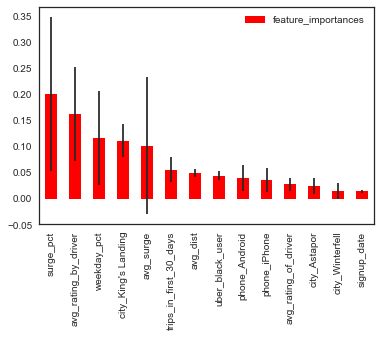

In [73]:
df_importances.plot(kind='bar', color='r',
       yerr=std[df_importances.index], align='center')
plt.xticks(range(X_train.shape[1]), df_importances.feature_name, rotation=90)

In [60]:
[tree.feature_importances_ for tree in clf.estimators_]

[array([0.05665906, 0.06200256, 0.02424388, 0.01606612, 0.01798398,
        0.35651783, 0.06144738, 0.04558042, 0.13698219, 0.06374923,
        0.02937868, 0.04261807, 0.01570857, 0.07106201]),
 array([0.05959913, 0.12278052, 0.02291088, 0.00899708, 0.01379052,
        0.34463829, 0.05051826, 0.04439829, 0.10219962, 0.02938123,
        0.09561943, 0.02431565, 0.0808511 , 0.        ]),
 array([0.04097322, 0.06412395, 0.09515815, 0.33401683, 0.01770637,
        0.03094855, 0.05441996, 0.04812266, 0.09460064, 0.01743277,
        0.12077854, 0.00311282, 0.04548407, 0.03312149]),
 array([0.05390379, 0.07402031, 0.02170566, 0.08446892, 0.00986242,
        0.03690483, 0.05604386, 0.04469028, 0.39185162, 0.02024374,
        0.08610047, 0.01544978, 0.08564213, 0.01911218]),
 array([0.05097645, 0.16763952, 0.02661005, 0.3432974 , 0.01746497,
        0.03324235, 0.05145769, 0.02809862, 0.0425184 , 0.01496441,
        0.14506679, 0.00872505, 0.01476163, 0.05517667]),
 array([0.04866911, 0.15261733